# Assignment #2 Sound Detection

Test  and able to edit the notebook! Looks good - Will LaForge

In [5]:
# mount the local google drive for access to the collected data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# root path for the collected data
root_dir='./drive/MyDrive/Colab Notebooks/COSC522/Assignment2/collected_data'

## Read in raw data files

In [397]:
from pandas.core.dtypes.common import classes_and_not_datetimelike
'''
Find the collected samples by class and store in lists related to each class
classes_data is a dictonary of the numpy arrays of data where the class is the key and the arrays are the data
'''
import os
import librosa
import scipy.io.wavfile as wavfile
import numpy as np

classes_data=[]
raw_micro_data=[]
raw_blender_data=[]
raw_music_data=[]
raw_siren_data=[]
raw_vaccum_data=[]
raw_control_data=[]

classes=['microwave','blender','music','siren','vaccum_cleaner', 'control']

# dict to capture raw data by class
classes_data = {
    'microwave':raw_micro_data, 
    'blender':raw_blender_data, 
    'music':raw_music_data, 
    'siren':raw_siren_data, 
    'vaccum_cleaner':raw_vaccum_data, 
    'control': raw_control_data
    }
class_dict={
    'microwave':1, 
    'blender':2, 
    'music':3, 
    'siren':4, 
    'vaccum_cleaner':5, 
    'control': 0
}

# iterate through classes (also the folder structure where raw data is stored)
for cls in classes:
  file_path = f"{root_dir}/{cls}/"
  # iterate through each file in the "class" folder
  for file in os.listdir(file_path):
    #fs,y = wavfile.read(file_path+file)
    y,fs=librosa.load(file_path+file,sr=None,dtype=np.float64)
    # add this files data to the raw data of this class
    classes_data[cls].append(y)

# convert lists back to numpy arrays
for cls in classes_data:
  for data in classes_data:
    data=np.array(data)
 
 
  classes_data[cls]=np.array(classes_data[cls]) 

print(fs)

44100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [587]:
[{x:f"Samples - {len(classes_data[x])}"} for x in classes_data]

[{'microwave': 'Samples - 5'},
 {'blender': 'Samples - 5'},
 {'music': 'Samples - 0'},
 {'siren': 'Samples - 0'},
 {'vaccum_cleaner': 'Samples - 5'},
 {'control': 'Samples - 10'}]

In [542]:
#len(classes_data['microwave'][0])

# Pre-processing
___

In [588]:
'''
FFT 
'''
# FFT example from Dr. Sai
from scipy import signal

def FFT(audio,fs,FFT_SIZE=1024):
  f,t,ppx = signal.spectrogram(audio, nperseg=FFT_SIZE, fs=fs) #noverlap=FFT_SIZE/2

  return ppx

In [589]:
# # FFT. Might need to use this to get a 2-D array
# from scipy.fftpack import fft

# def fft_method(audio, sampling_rate):
#     # variables
#     T = 1/sampling_rate
#     N = len(audio)
#     max_val = 1.0/(2.0*T) # max frequency spectrum of the FFT.
#     num_vals = N//2  
    
#     # calculate fft
#     yf_all = fft(audio)
    
#     xf = np.linspace(0.0, max_val, num_vals)
#     yf = 2.0/N * np.abs(yf_all[0:num_vals])
    
#     return xf, yf

In [590]:
# xf,yf=fft_method(classes_data['microwave'][0], fs)

# print(xf,yf)

# Data Analysis Pipeline
___

## 1. Feature Engineering



### 1.1  Binning

In [591]:
import cv2

# function for binning data 
def bin_data(ppx,fs,num_time_bins,num_freq_bins):
  p = FFT(ppx,fs)
  return cv2.resize(p[:,:],(num_time_bins,num_freq_bins))

### 1.2 Extracting domain-specific features

In [688]:
'''
Functions for extracting domain-specific features
'''
import numpy as np

def microwave_hum(audio):
  # looking for the "hum" of the microwave between the 1500 and 3000 ms timestamp 
  # the microwave hum in testing prodcued data points that had a median of 28.721306
  ppx=FFT(audio,fs)

  # if np.median(ppx[:40,1500:3000]) >= 60 and np.median(ppx[:40,1500:3000]) <=100:
  #   return 1
  # else:
  #   return 0
  return np.mean(ppx[:50,1000:2500])

def binned_microwave_hum(audio):
  # Open CV's resize takes (columns,rows) as the input for desired size
  ppx=FFT(audio,fs)

  resized_pxx=bin_data(ppx,fs,10,10)

  return np.mean(resized_pxx[0:3,9:10])

def mean_pitch(audio,fs=fs):

  # print(audio)

  pitches, magnitudes = librosa.piptrack(y=audio, sr=fs, n_fft=1024)

  return np.mean(pitches)

def mean_pitch_magnitude(audio,fs=fs):

  # print(audio)

  pitches, magnitudes = librosa.piptrack(y=audio, sr=fs, n_fft=1024)

  return np.mean(magnitudes)

### 1.3 Windowing Data

In [689]:
'''
Function to truncate audio files to same exact length
--must truncate the audio signal length for scaling and normalizaiton to work
--this function trims seconds from the begining of the file
@parameters:
--audio: raw audio file
--fs:  sampling rate
--max_len: the maximum in seconds that you wish the file to be <default=30 seconds>
returns:
--truncated signal to desired length
'''

def trunc_audio(audio, fs, max_len=30):

  sig_len=len(audio)/fs
  max_len=max_len

  if (sig_len > max_len):
    
    diff=int(round((sig_len-max_len)*fs,0))
      # Truncate the signal to the given length
    sig = audio[diff:]
      
    return sig


In [690]:

'''
Windowing and non-windowing
'''
from skimage.measure import block_reduce

# overall average of the entire recording
def no_win_average(audio):
  return np.average(audio)

# calculate an average of a windowed size of data
def windowed_average(audio, window_size=10, fs=fs):
  window_size = window_size * fs
  
  # code for selecting a subset of the entire data set
  limited_aud=trunc_audio(audio,fs) 
  avg_every_n_window = np.add.reduceat(limited_aud, np.arange(0, len(limited_aud), window_size))
  
  return avg_every_n_window



In [762]:
'''
Function for extracting features
--takes raw audio and extracts different features
'''

def featurize_input(audio):
  stft=np.abs(librosa.stft(audio))
  #print(audio)

  fv=[]
  # features go here
  fv.append(microwave_hum(audio))
  fv.append(binned_microwave_hum(audio))
  fv.append(no_win_average(audio))
  fv.extend(windowed_average(audio, 5, fs))
  # max pitch of the audio
  fv.append(mean_pitch(audio))
  #pitch magnitude of the audio
  fv.append(mean_pitch_magnitude(audio))
  # zero crossing rate -- screwed up the normalizaiton, scaling and model fit 
  fv.append(np.mean(librosa.feature.zero_crossing_rate(audio, frame_length=1048)))
  # mel spectrogram
  fv.append(np.mean(librosa.feature.melspectrogram(audio, sr=fs).T))
  # Chroma_StFt - Compute a chromagram from a waveform or power spectrogram
  fv.append(np.mean(librosa.feature.chroma_stft(S=stft, sr=fs).T))

  fv.append(mean_pitch(audio)*mean_pitch_magnitude(audio))

  fv=np.array(fv)

  return fv 

In [771]:
# np.max(max_pitch(classes_data['blender'][0],fs)) , np.max(max_pitch_magnitude(classes_data['blender'][0],fs))
for cls in classes_data:
  if len(classes_data[cls])>0:
    print(len(classes_data[cls]))
    for x in classes_data[cls]:
      print(cls, mean_pitch(x)*mean_pitch_magnitude(x))

5
microwave 0.39622731664472505
microwave 0.3349007308839148
microwave 0.3654166493605486
microwave 0.48561734585542476
microwave 0.5553620130526892
5
blender 11.426604681147571
blender 10.635617101922366
blender 19.14391736107956
blender 3.7428958659092713
blender 2.6974959791679964
5
vaccum_cleaner 16.314506380828043
vaccum_cleaner 16.656034742181692
vaccum_cleaner 16.057437741560175
vaccum_cleaner 17.2725889801032
vaccum_cleaner 18.926555587077765
10
control 0.012003322156703784
control 0.009819673407285909
control 0.015699802954509116
control 0.008787989850409466
control 0.008807433307864742
control 0.00637451219810199
control 0.009342405689266548
control 0.012591935924884584
control 0.014219616426028077
control 0.015111104232822139


In [772]:

features=[]

for cls in classes_data:
  if len(classes_data[cls])>0:
    for x in classes_data[cls]:
      features.append([featurize_input(x),class_dict[cls]])
        
features=np.array(features) 

# features

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [773]:
import pandas as pd

comb_data=pd.DataFrame(features,columns=['features','labels'])
comb_data=comb_data.fillna(0)
comb_data.head()

,features,labels
0,"[4.68003559040841e-07, 1.5685168353325412e-18,...",1
1,"[4.5913744342247506e-07, 2.885897922144064e-18...",1
2,"[4.785559240071612e-07, 4.000323764473901e-18,...",1
3,"[5.161596140165477e-07, 2.690807341315253e-18,...",1
4,"[5.378307196734046e-07, 3.2928974093124486e-17...",1


In [774]:
# extract data and labels from dataframe
data=np.array(comb_data['features'].tolist())
labels=np.array(comb_data['labels'].tolist())

In [782]:
print(data.shape)
print(labels.shape)

labels=np.array(labels)
[x for x in data[20]]

(25, 15)
(25,)


[0.001134254128603733,
 1.3870775951805475e-25,
 0.38112151906539193,
 0.3176912565734742,
 0.4490867452382282,
 0.31572743839128686,
 0.4008481095904009,
 0.790664554213938,
 0.5639344664227591,
 0.0,
 0.007150390720575335,
 0.009753269501680761,
 0.000891157583495103,
 0.7079542826612312,
 0.0]

## 2. Feature Normalization / Visualization

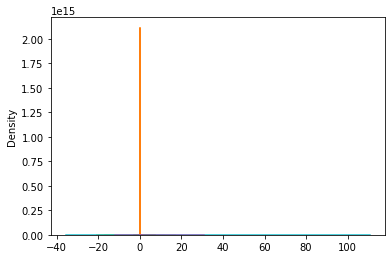

In [777]:
import seaborn as sns

for i in range(data.shape[1]):
  sns.kdeplot(data[:,i])

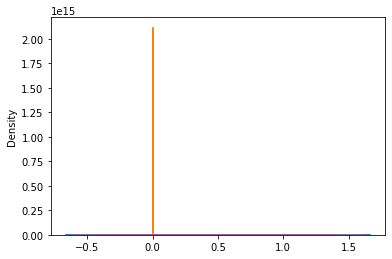

In [781]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler

#scaler = RobustScaler()
scaler = MinMaxScaler()

data = scaler.fit_transform(data)
for i in range(data.shape[1]):
    sns.kdeplot(data[:,i])

## 3. ML Models for classification
---

In [780]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score

# spliting the data into train and test data sets
x_train, xtest, y_train, ytest = train_test_split(data, labels, test_size=0.30, random_state=42)

# oversampling the train set here just before training the model
#sm = SMOTE(random_state=42)
#x_train,y_train=sm.fit_resample(x_train,y_train)
#print(f"Resampled Test Data {len(x_train)}, Labels {len(y_train)}", end='\n\n')

xtrain,ytrain=x_train,y_train

#training the model
clf = SVC(kernel='rbf') 
# clf=KNeighborsClassifier(n_neighbors=3)

clf.fit(xtrain, ytrain)
cv_scores = cross_val_score(clf, xtrain, ytrain, cv=3)
print(f'Average Cross Validation Score from Training:  {cv_scores.mean()}', sep='\n', end='\n')
print(f'Average Cross Validation Score STD from Training:  {cv_scores.std()}', sep='\n', end='\n\n\n')

#testing the model
ypred = clf.predict(xtest)
# cm = confusion_matrix(ytest, ypred) #using a crosstab table to display more info about the predictions
cm = pd.crosstab(ytest.ravel(), ypred.ravel(), rownames = ['True'], colnames = ['Predicted'], margins = True)
cr = classification_report(ytest, ypred)

print('Confusion Matrix:', cm, sep='\n', end='\n\n\n')
print('Test Statistics:', cr, sep='\n', end='\n\n\n')

#This is what we will be grading (>95 expected)
print('Testing Accuracy:', accuracy_score(ytest, ypred), end='\n\n\n')

Average Cross Validation Score from Training:  0.5888888888888889
Average Cross Validation Score STD from Training:  0.0684934889218775


Confusion Matrix:
Predicted  0  1  2  All
True                   
0          2  0  0    2
1          1  1  0    2
2          0  0  2    2
5          1  0  1    2
All        4  1  3    8


Test Statistics:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         2
           1       1.00      0.50      0.67         2
           2       0.67      1.00      0.80         2
           5       0.00      0.00      0.00         2

    accuracy                           0.62         8
   macro avg       0.54      0.62      0.53         8
weighted avg       0.54      0.62      0.53         8



Testing Accuracy: 0.625




/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
